In [1]:
from numpy import linalg as LA
import os
import pandas as pd
import numpy as np
from scipy.signal import find_peaks_cwt
import pickle
from pathlib import Path
from scipy.stats import kurtosis, skew
from scipy.stats import iqr
from pyentrp import entropy as ent
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize
import sys
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import matplotlib.pyplot as plt
import math
#from tony_beltramelli_detect_peaks import detect_peaks

%matplotlib inline

In [2]:
roll = [0.12, 2.56, -5.67, 8.432]

rms_roll = np.sqrt(np.mean([x**2 for x in roll]))

print rms_roll

5.23964512157


## Compute features for accelerometer only

In [17]:
#Helper Functions

def Signal_magnitude_area(x,y,z):

        sum = 0    
        for i in range(len(x)):
            sum += (abs(x[i]) + abs(y[i]) + abs(z[i]))

        return float(sum)/len(x)


def Power(x):

    power = (LA.norm(x)**2)/ len(x)
    return power


def number_of_peaks(window):
    indexes = find_peaks_cwt(window, np.arange(1, len(window)))
    return len(indexes)


def number_of_peaks2(window):

    print('Detect peaks with height threshold.')
    indexes = detect_peaks(vector, 1.5)
    return len(indexes)

def trim_first_last_n_seconds(df, n, freq):
    if df.shape[0] < 6001:
        return None

    remove_indexes = list(range(0, int(n*1000/freq)))
    df = df.drop(remove_indexes)

    remove_indexes = list(range(df.shape[0] - int(n*1000/freq), df.shape[0]-1))
    df = df.drop(remove_indexes)

    return df

def compute_accelerometer(in_dir, ignore_pickle=False):
    label_map = {}
    label_map['walking']=0
    label_map['laying_down']=1
    label_map['sitting']=2
    label_map['standing']=3
    features = []
    labels = []
    trim_num_seconds = 10
    acc_freq = 4
    window_num_seconds = 4 #seconds
    steps_per_sec = int(1000/acc_freq)
    window_size = int(window_num_seconds*steps_per_sec)
    window_step = 2 #seconds
    window_jump_steps = int(window_step*steps_per_sec)

    print("Window_size, Window_jump_steps: ", window_size, window_jump_steps)

    #this function assumes that records are evenly spaced



    dfs_list = []
    #features = []
    #labels = []

    
    pickle_file = Path("pickles_split/accelerometer_features.pickle")

    if pickle_file.exists() and not ignore_pickle:
        print("Found pickle files for accelerometer")
        features = pickle.load(open("pickles_split/accelerometer_features.pickle", "rb"))
        labels = pickle.load(open("pickles_split/accelerometer_labels.pickle", "rb"))
        dfs_list = pickle.load(open("pickles_split/accelerometer_dfs_list.pickle", "rb"))

    else:

        for root, dirs, files in os.walk(in_dir):
            path = root.split(os.sep)

            for f in files:
                print("/".join(path) + "/" + f)

                full_path = "/".join(path) + "/" + f

                if "gyroscope" in full_path:
                    print("Skip ", full_path)
                    continue

                df = pd.read_csv(full_path, header=None)

                print("Before trimming: ", df.shape)

                df = trim_first_last_n_seconds(df, trim_num_seconds, acc_freq)
                if df is None:
                    print("Continuing")
                    continue

                print("After trimming: ", df.shape)

                #Sample the data according to the size of the window with 50% overlap
                for index in range(0, df.shape[0]-window_size, window_jump_steps):
                    indexes = list(range(index, index + int(window_size)))

                    window = df.iloc[indexes,:]

                    X_list = window[1].tolist()
                    Y_list = window[2].tolist()
                    Z_list = window[3].tolist()


                    #Generate the features for this window


           # ****************** Time-Domain Features ************************* #

                    #Mean of the signals
                    mean_x = np.mean(X_list)
                    mean_y = np.mean(Y_list)
                    mean_z = np.mean(Z_list)

                    #Variance of the signals
                    var_x = np.var(X_list)
                    var_y = np.var(Y_list)
                    var_z = np.var(Z_list)

                    #Number of peaks in the signals
                    #num_peaks_x = number_of_peaks(X_list)
                    #num_peaks_y = number_of_peaks(Y_list)
                    #num_peaks_z = number_of_peaks(Z_list)            

                    #Median of the signals
                    median_x = np.ma.median(X_list)
                    median_y = np.ma.median(Y_list)
                    median_z = np.ma.median(Z_list)

                    #Standard Deviation of the signals
                    std_x = np.std(X_list)
                    std_y = np.std(Y_list)
                    std_z = np.std(Z_list)

                    #Compute Signal Magnitude Area
                    signal_mag_area = Signal_magnitude_area(X_list, Y_list, Z_list)

                    #Maximum and Minimum values and their indexes
                    max_x = max(X_list)
                    #max_index_x = X_list.index(max_x)               
                    min_x = min(X_list)
                    #min_index_x = X_list.index(min_x)

                    max_y = max(Y_list)
                   #max_index_y = Y_list.index(max_y)              
                    min_y = min(Y_list)
                    #min_index_y = Y_list.index(min_y)               

                    max_z = max(Z_list)
                    #max_index_z = Z_list.index(max_z)             
                    min_z = min(Z_list)
                    #min_index_z = Z_list.index(min_z)


                    #Power of X,Y and Z signals             
                    power_x = Power(X_list)
                    power_y = Power(Y_list)
                    power_z = Power(Z_list)


                    #Skewness and Kurtosis
                    skew_x = skew(X_list)
                    skew_y = skew(Y_list)
                    skew_z = skew(Z_list)

                    kurtosis_x = kurtosis(X_list)                
                    kurtosis_y = kurtosis(Y_list)
                    kurtosis_z = kurtosis(Z_list)


                    #Entropy of the signals (Can experiment with different types of Entropy)
                    entropy_x = ent.shannon_entropy(X_list)
                    entropy_y = ent.shannon_entropy(Y_list)
                    entropy_z = ent.shannon_entropy(Z_list)


                    #Interquartile range of the signals
                    iqr_x = iqr(X_list)
                    iqr_y = iqr(Y_list)
                    iqr_z = iqr(Z_list)


                    #Cross Correlation 
                    corr_x_y = np.correlate(X_list, Y_list)[0]
                    corr_y_z = np.correlate(Y_list, Z_list)[0]
                    corr_x_z = np.correlate(X_list, Z_list)[0]


                    
                    #Pitch and Roll Information (for rotation)
                    roll = []
                    pitch = []
                    for index in range(0,len(X_list)):                       
                        roll.append(math.atan2(Y_list[index]/9.81, Z_list[index]/9.81) * 57.3)
                        pitch.append(math.atan2(X_list[index]/9.81, Z_list[index]/9.81) * 57.3)
                    
                    #Mean of the roll and pitch
                    mean_roll = np.mean(roll)
                    mean_pitch = np.mean(pitch)
                    
                    #RMS of roll and pitch
                    #rms_roll = np.sqrt(np.mean(roll**2))
                    rms_roll = np.sqrt(np.mean([x**2 for x in roll]))
                    rms_pitch = np.sqrt(np.mean([x**2 for x in pitch]))            
                    #rms_pitch = np.sqrt(np.mean(pitch**2))
                                      
                    #Zero Crossing Rate for roll and pitch
                    frame = roll
                    count = len(frame)
                    countZ = np.sum(np.abs(np.diff(np.sign(frame)))) / 2
                    zcr_roll = np.float64(countZ) / np.float64(count-1.0)
                    
                    frame = pitch
                    count = len(frame)
                    countZ = np.sum(np.abs(np.diff(np.sign(frame)))) / 2
                    zcr_pitch = np.float64(countZ) / np.float64(count-1.0)
                    

        # ****************** Frequency-Domain Features ************************* #


                    coeff_X = np.fft.fft(X_list)
                    coeff_Y = np.fft.fft(Y_list)
                    coeff_Z = np.fft.fft(Z_list)


                    #Normalized FFT coefficients
                    fft_x = LA.norm(coeff_X)              
                    fft_y = LA.norm(coeff_Y)   
                    fft_z = LA.norm(coeff_Z)  


                    #Energy in the frequency Domain
                    Energy_x = sum(abs(coeff_X**2))/len(X_list)
                    #sum(abs(coeff_X)**2)/len(x1)
                    Energy_y = sum(abs(coeff_Y**2))/len(Y_list)
                    Energy_z = sum(abs(coeff_Z**2))/len(Z_list)


                    #Store the features
                    window_feature = []
                    window_feature.append(mean_x)
                    window_feature.append(mean_y)
                    window_feature.append(mean_z)

                    window_feature.append(var_x)
                    window_feature.append(var_y)
                    window_feature.append(var_z)

                    window_feature.append(median_x)
                    window_feature.append(median_y)
                    window_feature.append(median_z)

                    window_feature.append(std_x)
                    window_feature.append(std_y)
                    window_feature.append(std_z)


                    window_feature.append(signal_mag_area)

                    window_feature.append(max_x)
                    #window_feature.append(max_index_x)
                    window_feature.append(min_x)
                    #window_feature.append(min_index_x)

                    window_feature.append(max_y)
                    #window_feature.append(max_index_y)
                    window_feature.append(min_y)
                    #window_feature.append(min_index_y)

                    window_feature.append(max_z)
                    #window_feature.append(max_index_z)
                    window_feature.append(min_z)
                    #window_feature.append(min_index_z)

                    window_feature.append(power_x)
                    window_feature.append(power_y)
                    window_feature.append(power_z)

                    window_feature.append(skew_x)
                    window_feature.append(kurtosis_x) 

                    window_feature.append(skew_y)
                    window_feature.append(kurtosis_y) 

                    window_feature.append(skew_z)
                    window_feature.append(kurtosis_z) 

                    window_feature.append(entropy_x)
                    window_feature.append(entropy_y)
                    window_feature.append(entropy_z)

                    window_feature.append(iqr_x)
                    window_feature.append(iqr_y)
                    window_feature.append(iqr_z)

                    window_feature.append(corr_x_y)
                    window_feature.append(corr_y_z)
                    window_feature.append(corr_x_z)
                    
                    window_feature.append(mean_roll)
                    window_feature.append(mean_pitch)
                    window_feature.append(rms_roll)
                    window_feature.append(rms_pitch)
                    
                    window_feature.append(zcr_roll)
                    window_feature.append(zcr_pitch)

                    window_feature.append(fft_x)
                    window_feature.append(fft_y)
                    window_feature.append(fft_z)

                    window_feature.append(Energy_x)
                    window_feature.append(Energy_y)
                    window_feature.append(Energy_z)

                    #window_feature.append(num_peaks_x)
                    #window_feature.append(num_peaks_y)
                    #window_feature.append(num_peaks_z)

                    #scale = preprocessing.minmax_scale(data, feature_range=(-0.5, 0.5))

                    features.append(window_feature)

                    #Store the label
                    labels.append(label_map[df[5].iloc[1]])

                #dfs_list.append(df)

        #dfs = pd.concat(dfs_list)

        if not ignore_pickle:

            pickle.dump(features, open("pickles_split/accelerometer_features.pickle", "wb"), protocol=2)
            pickle.dump(labels, open("pickles_split/accelerometer_labels.pickle", "wb"), protocol=2)
            pickle.dump(dfs_list, open("pickles_split/accelerometer_dfs_list.pickle", "wb"), protocol=2)

    features = np.asarray(features)
    labels = np.asarray(labels)
    
    return features, labels

In [11]:
def getModel(modelName, args):
    
    if modelName == 'LogisticRegression':
        model = LogisticRegression(random_state=42)
        
    if modelName == 'SVC':
        model = SVC(random_state=42, kernel=args[0], C=args[1], decision_function_shape=args[2])
        
    if modelName == 'DecisionTreeClassifier':
        model = DecisionTreeClassifier(random_state=42, max_features=args[0], criterion=args[1])
        
    if modelName == 'RandomForestClassifier':
        model = RandomForestClassifier(n_estimators=args[0], criterion=args[1], max_features=args[2], max_depth=args[3], oob_score=True, random_state=42)
        
    if modelName == 'MLPClassifier':
        model = MLPClassifier(hidden_layer_sizes=args[0], activation=args[1], solver=args[2], random_state=42, max_iter=500)
        
    return model

In [12]:

def run_kfold(features, labels, num_splits, modelName, args=None, verbose=False):
    
    X = np.array(normalize(features))
    y = np.array(labels)

    kf = KFold(n_splits=num_splits, random_state=None, shuffle=True)
    kf.get_n_splits(X)

    foldAccuracy = list()
    foldPrecision = list()
    foldRecall = list()
    bestModel = None
    bestAccuracy = float(sys.maxsize) * (-1)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = getModel(modelName, args)

        model.fit(X_train, y_train)

        prediction = model.predict(X_test)

        if verbose:
            print("\nFold: ", fold)
            print("Confusion Matrix:")
            cm = metrics.confusion_matrix(yTest, prediction)
            print(cm)
            plt.matshow(cm, cmap = plt.cm.Oranges)
            plt.title('Confusion matrix')
            plt.colorbar()
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.show()

        accuracy = metrics.accuracy_score(y_test, prediction)
        precision = metrics.precision_score(y_test, prediction, average = None)
        recall = metrics.recall_score(y_test, prediction, average = None)

        foldAccuracy.append(accuracy)
        foldPrecision.append(precision)
        foldRecall.append(recall)
        
        if accuracy > bestAccuracy:
            bestAccuracy = accuracy
            bestModel = model
                
    print("\nBest Accuracy: ", bestAccuracy)
    
    return bestModel, foldAccuracy, foldPrecision, foldRecall        

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()

In [14]:
from sklearn.metrics import confusion_matrix
import itertools
#from xgboost import XGBClassifier
from collections import Counter
def module_1(features,labels, test_features,test_labels):
    print(features.shape)
    #print(labels.shape)

    le = preprocessing.LabelEncoder()
    scaler = preprocessing.StandardScaler()
    #X = scaler.fit_transform(features)
    X = features
    #X = np.array(preprocessing.scale(features))
    y = le.fit_transform(labels)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    #model = LogisticRegression(penalty='l1')
    #model = MLPClassifier(hidden_layer_sizes=(50,100), activation='tanh', solver='lbfgs', random_state=42, max_iter=500)
    model = DecisionTreeClassifier(random_state=42, max_features=25, criterion='gini')
    #model = XGBClassifier()
    #model = RandomForestClassifier(n_estimators=40, criterion='gini', max_features=10, max_depth=15,random_state=42)
    model.fit(X_train, y_train)


    X = X_test
    y = y_test
    prediction = model.predict(X)
    accuracy = metrics.accuracy_score(y, prediction)
    precision = metrics.precision_score(y, prediction, average = None)
    print(accuracy)
    print(precision)
    cnf_matrix = confusion_matrix(y,prediction)
    plot_confusion_matrix(cnf_matrix, classes=le.classes_,
                          title='Confusion matrix, without normalization')

    X = features
    y = le.fit_transform(labels)
    model.fit(X, y)
    
    X = test_features
    y = le.transform(test_labels)

    #X = X_test
    #y = y_test

    #print(X.shape)
    #print(y.shape)

    prediction_test = model.predict(X)

    accuracy = metrics.accuracy_score(y, prediction_test)
    precision = metrics.precision_score(y, prediction_test, average = None)
    # recall = metrics.recall_score(y_test, prediction, average = None)
    print(accuracy)
    print(precision)
    print(Counter(prediction_test))
    cnf_matrix = confusion_matrix(y,prediction_test)
    plot_confusion_matrix(cnf_matrix, classes=le.classes_,
                          title='Confusion matrix, without normalization')
    print(len(prediction),len(prediction_test))
    return prediction_test
    

In [ ]:
train = True
test = True

test_dir = 'test3'
train_dir = 'data_3_8_2018'

if train:
    features = []
    labels = []
    features, labels = compute_accelerometer(train_dir, ignore_pickle=True)
    
if test:
    test_features = []
    test_labels = []
    test_features, test_labels = compute_accelerometer(test_dir,  ignore_pickle=True)

print features.shape
print test_features.shape

('Window_size, Window_jump_steps: ', 1000, 500)
data_3_8_2018/0_1_android.sensor.accelerometer.data.csv
('Before trimming: ', (40642, 6))
('After trimming: ', (35643, 6))
data_3_8_2018/0_4_android.sensor.gyroscope.data.csv
('Skip ', 'data_3_8_2018/0_4_android.sensor.gyroscope.data.csv')
data_3_8_2018/10_1_android.sensor.accelerometer.data.csv
('Before trimming: ', (137412, 6))
('After trimming: ', (132413, 6))


In [9]:
print(np.unique(labels))
print(np.unique(test_labels))
print(Counter(labels))
print(Counter(test_labels))

[0 1 2 3]
[0 1 2 3]
Counter({0: 3148, 1: 3004, 2: 2842, 3: 2738})
Counter({0: 3148, 1: 3004, 2: 2842, 3: 2738})


In [55]:
labels_mod1 = [4 if not x==0 else 0 for x in labels]
test_labels_mod1 = [4 if not x==0 else 0 for x in test_labels]

In [56]:
print(np.unique(labels_mod1))
print(np.unique(test_labels_mod1))


[0 4]
[0 4]


(11732, 49)
0.979557069847
[ 0.96529968  0.98483081]
Confusion matrix, without normalization
[[306  13]
 [ 11 844]]


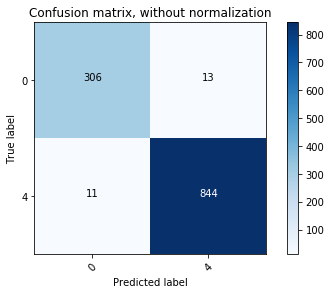

1.0
[ 1.  1.]
Counter({1: 8584, 0: 3148})
Confusion matrix, without normalization
[[3148    0]
 [   0 8584]]


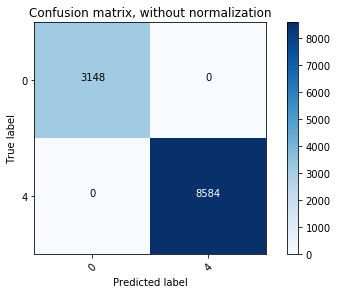

(1174, 11732)


In [57]:
prediction_test_mod1 = module_1(features,labels_mod1, test_features,test_labels_mod1)

In [61]:
print(Counter(labels))

Counter({0: 3148, 1: 3004, 2: 2842, 3: 2738})


In [58]:
def get_bool_filter(lst, bools):
    nl = []
    for i,j in zip(lst,bools):
        if(j):
            nl.append(i)
    return nl

In [59]:
bool_mod1 = [False if x==0 else True for x in labels]
test_bool_mod1 = [False if x==0 else True for x in prediction_test_mod1]
print(Counter(bool_mod1),Counter(test_bool_mod1))

(Counter({True: 8584, False: 3148}), Counter({True: 8584, False: 3148}))


In [43]:
labels_mod2 = get_bool_filter(labels, bool_mod1)
test_labels_mod2 = get_bool_filter(test_labels, test_bool_mod1)

In [44]:
features_mod2 = np.asarray(get_bool_filter(features,bool_mod1))
test_features_mod2 = np.asarray(get_bool_filter(test_features,test_bool_mod1))

(8584, 49)
0.895227008149
[ 0.93728223  0.85234899  0.89781022]
Confusion matrix, without normalization
[[269  13   4]
 [  9 254  24]
 [  9  31 246]]


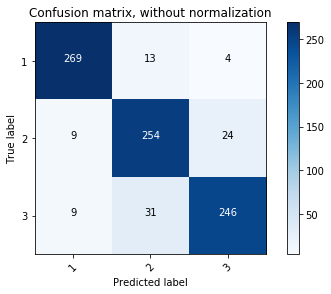

1.0
[ 1.  1.  1.]
Confusion matrix, without normalization
[[3004    0    0]
 [   0 2842    0]
 [   0    0 2738]]


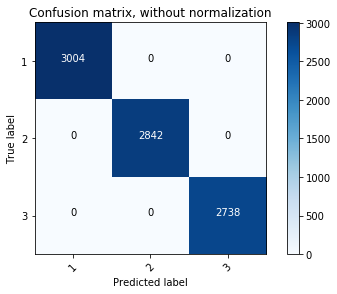

(859, 8584)


In [46]:
prediction_test_mod2 = module_1(features_mod2,labels_mod2, test_features_mod2,test_labels_mod2)

In [52]:
total_pred = []
i = 0
j=0
for x in range(len(test_labels)):
    if(prediction_test_mod1[x] == 0):
        total_pred.append(0)
    else:
        total_pred.append(prediction_test_mod2[j])
        j+=1
print(Counter(test_labels))
print(Counter(total_pred))

Counter({0: 3148, 1: 3004, 2: 2842, 3: 2738})
Counter({0: 6152, 1: 2842, 2: 2738})


[0 1 2 3]


(array([ 3148.,     0.,     0.,  3004.,     0.,     0.,  2842.,     0.,
            0.,  2738.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

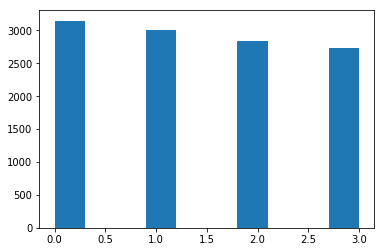

In [51]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(labels)
print(le.classes_)
plt.hist(y)